In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation as R
import scipy.spatial.transform as transform
from scipy.spatial import ConvexHull, Delaunay
import time

## Ellipsoids

1) Generate points on a unit sphere using Fibonacci lattice

2) Scale points using the ellipsoidal semi-axes $a, b, c$ where $a > b > c$

In [2]:
def generate_ellipsoid(n, a, b, c):
    indices = np.arange(0, n, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / n)  #uniform distribution in latitude
    theta = (np.pi * (1 + 5**0.5) * indices) % (2 * np.pi)  #Fibonacci spiral in longitude

    #spherical to Cartesian coordinates
    x = a * np.sin(phi) * np.cos(theta)
    y = b * np.sin(phi) * np.sin(theta)
    z = c * np.cos(phi)

    ellipsoid_points = np.vstack((x, y, z)).T
    
    #print(ellipsoid_points)
    return ellipsoid_points

def rotate_ellipsoid(points, phi, theta, psi):
    rotation = R.from_euler('zxy', [phi, theta, psi], degrees=True)
    rotated_points = rotation.apply(points)
    return rotated_points

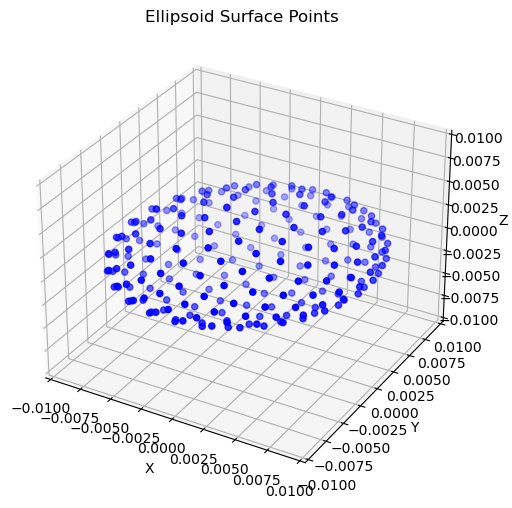

In [14]:
def plot_ellipsoid(points, a, b, c):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ellipsoid Surface Points')
    
    #set equal AR so we can actually see the shape
    max_radius = max(a, b, c)
    ax.set_xlim([-max_radius, max_radius])
    ax.set_ylim([-max_radius, max_radius])
    ax.set_zlim([-max_radius, max_radius])
    
    plt.show()

n = 250
a = 0.01; b = 0.0075; c = 0.005
phi = 45; theta = 0; psi = 0
ellipsoid_points = generate_ellipsoid(n, a, b, c)
rotated_ellipsoid_points = rotate_ellipsoid(ellipsoid_points, phi, theta, psi)
plot_ellipsoid(rotated_ellipsoid_points, a, b, c)

In [15]:
def check_unique(points, tol=1e-6):
    tree = KDTree(points)  #KD-tree for fast nearest-neighbor search
    unique_mask = np.ones(len(points), dtype=bool)  #track unique points

    for i in range(len(points)):
        if unique_mask[i]:  #"if the point is still marked as unique"
            neighbors = tree.query_ball_point(points[i], tol)  #find close points
            unique_mask[neighbors] = False  # Mark all neighbors as non-unique
            unique_mask[i] = True  #keep the first occurrence as unique

    unique_count = np.sum(unique_mask)  #remaining unique points
    total_count = len(points)
    
    return unique_count, total_count

u_count_tol, t_count_tol = check_unique(rotated_ellipsoid_points, tol=1e-6)

u_count_tol, t_count_tol

(250, 250)

In [16]:
def average_distance(points):
    tree = KDTree(points)  #KD-tree for fast nearest-neighbor search
    distances, _ = tree.query(points, k=2)  #nearest neighbor for each point
    avg_distance = np.mean(distances[:, 1])  #exclude self-distance (first column)
    return avg_distance

avg_dist1 = average_distance(rotated_ellipsoid_points)

avg_dist1

#sqrt(surface area of ellipsoid / N

0.0015147036622813546

### Surface Area Using Knud Thomsen's Formula

$$ S \approx 4\pi \bigg[ \frac{a^p b^p + a^p c^p + b^p c^p}{3} \bigg]^{\frac{1}{p}}$$

where $ p \approx 1.6075$ yields a relative error of at most 1.061%

https://www.numericana.com/answer/ellipsoid.htm#thomsen

In [17]:
def knud(a, b, c, n):
    p = 1.6075
    
    S = 4 * np.pi * ((a**p * b**p + a**p * c**p + b**p * c**p) / 3)**(1/p)
    
    return np.sqrt(S / n)

avg_dist2 = knud(a, b, c, n)

avg_dist2

0.001670359475380826

In [18]:
def S_func_ellipsoid(x, x0, eps, a, b, c):
    radius = np.linalg.norm(x - x0)
    epsilon = eps  
    
    #could be missing normalization (decide after validation)
    p1 = np.eye(3) * ((radius**2 + 2 * epsilon**2) / (radius**2 + epsilon**2)**(3/2))
    p2 = (1 / (radius**2 + epsilon**2)**(3/2)) * np.outer(x - x0, x - x0)
    return p1 + p2

def MRS_ellipsoid(n, a, b, c, phi, theta, psi):
    points = generate_ellipsoid(n, a, b, c)
    rotated_points = rotate_ellipsoid(points, phi, theta, psi)
    N = len(rotated_points)
    
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec
    #vel = np.tile(velocity, N)
    v = vel.reshape(-1, 1)
    
    d = (a + b + c) / 3
    eps = average_distance(rotated_points)
    #eps = knud(a, b, c, n)
    
    M = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(N):
            for k in range(3):
                for l in range(3):
                    S = S_func_ellipsoid(rotated_points[j], rotated_points[i], eps, a, b, c)
                    M[3*i+k][3*j+l] = S[k][l]   
    
    F = np.linalg.solve(M, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = np.array([Fx, Fy, Fz])
    
    return rotated_points, F, F_vector

In [19]:
rotated_ellipsoid_points, F, F_vector = MRS_ellipsoid(n, a, b, c, phi, theta, psi)

print(np.linalg.norm(F_vector))

0.0057759514218115576


In [20]:
def plot_MRS_ellipsoid(rotated_ellipsoid_points, F, F_vector, a, b, c):
    N = len(rotated_ellipsoid_points)
    
    u_inf = 1
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec
    v = vel.reshape(-1, 1)
    
    Nx, Ny, Nz = 20, 20, 1  #resolution
    Ngrid = Nx * Ny * Nz

    #define domain size based on ellipsoid size
    r_ellipsoid = max(a, b, c) / 2
    x0, x1 = -3 * r_ellipsoid, 3 * r_ellipsoid
    y0, y1 = -3 * r_ellipsoid, 3 * r_ellipsoid
    #@z0, z1 = -r_ellipsoid, r_ellipsoid
    z0, z1 = 0, 1

    dx, dy, dz = (x1 - x0) / (Nx - 1), (y1 - y0) / (Ny - 1), (z1 - z0)

    fv_points = []
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                fv_points.append([x_coord, y_coord, z_coord])
    FV_points = np.array(fv_points)

    M1 = np.zeros((3 * Ngrid, 3 * N))
    eps = average_distance(rotated_ellipsoid_points)
    d = (a + b + c) / 3  #characteristic length???

    for i in range(Ngrid):
        for j in range(N):
            S = S_func_ellipsoid(rotated_ellipsoid_points[j], FV_points[i], eps, a, b, c)
            M1[3*i:3*i+3, 3*j:3*j+3] = S

    FV_vel = M1 @ F
    FV_vel_matrix = np.reshape(FV_vel, (-1, 3))

    tolerance = 0.00075
    cross_section_points = rotated_ellipsoid_points[np.abs(rotated_ellipsoid_points[:, 2]) < tolerance]
    x_coords_cs = cross_section_points[:, 0]
    y_coords_cs = cross_section_points[:, 1]

    x_coords, y_coords, u, v = [], [], [], []
    k = 0
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                x_coord = x0 + x * dx
                y_coord = y0 + y * dy
                z_coord = z0 + z * dz
                radius = np.sqrt(x_coord**2 + y_coord**2)

                if radius > r_ellipsoid and abs(z_coord) < 0.5 * dz:
                    x_coords.append(x_coord)
                    y_coords.append(y_coord)
                    u.append(FV_vel[3 * k + 0] + u_inf) 
                    v.append(FV_vel[3 * k + 1])
                k += 1

    hull = ConvexHull(rotated_ellipsoid_points)
    hull_delaunay = Delaunay(rotated_ellipsoid_points)

    filtered_x_coords, filtered_y_coords, filtered_u, filtered_v = [], [], [], []
    k = 0
    for i in range(len(x_coords)):
        point = np.array([x_coords[i], y_coords[i], 0])
        if not hull_delaunay.find_simplex(point) >= 0:
            filtered_x_coords.append(x_coords[i])
            filtered_y_coords.append(y_coords[i])
            filtered_u.append(u[i])
            filtered_v.append(v[i])
    fig, ax = plt.subplots()
    ax.quiver(filtered_x_coords, filtered_y_coords, filtered_u, filtered_v)
    ax.scatter(x_coords_cs, y_coords_cs, color='b', marker='o')
    ax.set_xlabel('X-Axis')
    ax.set_ylabel('Y-Axis')
    ax.set_title('Filtered 2D Velocity Field Around Rotated Cube using Convex Hull')
    plt.show()

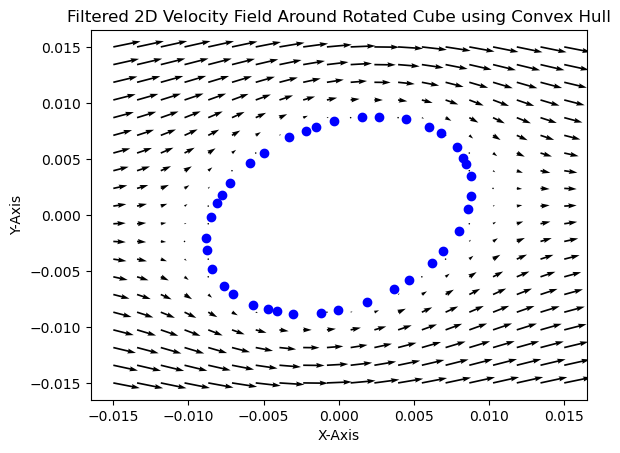

In [21]:
plot_MRS_ellipsoid(rotated_ellipsoid_points, F, F_vector, a, b, c)

### Bad Validation
1) Resistance force relation (Eq. 3.1):
$$ F_i = \mu A_{ij}U_j $$

2) Resistance function definitions (Table 2), which give $X_A$ and $Y_A$ based on eccenticity
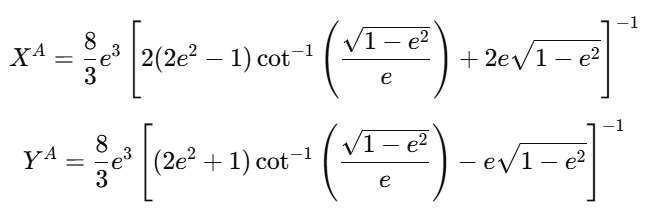

3) Equation 2.9, but use resistance matrix instead?

In [26]:
a = 0.01  # m
b = 0.0075  # m
c = 0.005  # m
mu = 1.0
U = np.array([1, 0, 0])

e = np.sqrt(1 - (c**2 / a**2))

#inverse cotangent function (cot^-1(x) = arctan(1/x))
cot_inv_term = np.arctan(1 / (np.sqrt(1 - e**2) / e))

XA_oblate = (8/3) * e**3 / (2 * (2*e**2 - 1) * cot_inv_term + 2*e * np.sqrt(1 - e**2))
YA_oblate = (8/3) * e**3 / ((2*e**2 + 1) * cot_inv_term - e * np.sqrt(1 - e**2))

A_matrix_oblate = np.diag([XA_oblate * a, YA_oblate * b, YA_oblate * c])


F_drag_oblate = mu * A_matrix_oblate @ U

F_drag_oblate

array([0.00905305, 0.        , 0.        ])

## Validation

Brenner 1983 (PDF 168, Book 155) [EQN (4-30.8)]

$$ F_z = -\frac{8 \pi \mu c U}{(\tau_0^2 +1)coth^{-1}(\tau_0) - \tau_0} $$

where $c=\sqrt{a^2 - b^2}$, $a$ and $b$ are the polar and equatorial radii, $\tau_0$ is:
$$ \tau_0 = \frac{a}{c} = \Big[1- \big(\frac{b}{a} \big)^2 \Big]^{-1/2}$$

In [30]:
n1 = 250
a1 = 0.01; b1 = 0.005; c1 = 0.005
phi1 = 0; theta1 = 0; psi1 = 0
mu1 = 1.0
U1 = 1.0
U0 = np.array([-U1, 0, 0])

points1, F1, F_vector1 = MRS_ellipsoid(n1, a1, b1, c1, phi1, theta1, psi1)

print(F_vector1)
print(np.linalg.norm(F_vector1))

[-4.82350724e-03 -5.76817981e-09 -5.69001767e-08]
0.004823507243199982


In [31]:
def brenner_fz(mu, U, a, b):
    c_= np.sqrt(a**2 - b**2)
    tau_0 = a / c_
    tau_0 = (1 - (b / a)**2 )**(-1/2)
    
    denominator = (tau_0**2 + 1) * np.arctanh(1 / tau_0) - tau_0
    
    numerator = 8 * np.pi * mu * c_ * U
    
    
    return - numerator/denominator

print(brenner_fz(mu1, U1, a1, b1))

-0.11346876506622713


Brenner 1983 (PDF 239, Book 226) [EQN (5-11.36) & (5-11.37)
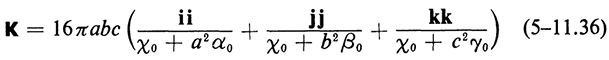

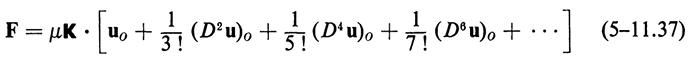

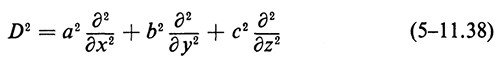

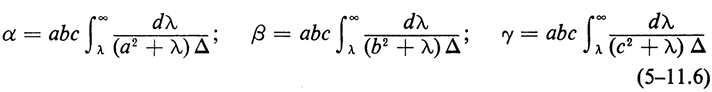

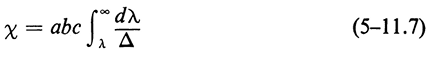

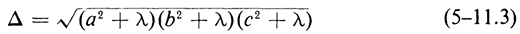

In [32]:
def compute_resistance(mu, U0, a, b, c):
    #(5.11.3)
    def Delta(lamb, a, b, c):
        return np.sqrt((a**2 + lamb) * (b**2 + lamb) * (c**2 + lamb))
    
    #(5-11.7)
    integral1, _ = integrate.quad(lambda l: 1 / Delta(l, a, b, c), 0, np.inf, limit=1000)
    chi = a * b * c * integral1
    print("Chi:", chi)
    
    #(5-11.6)
    integral_alpha, _ = integrate.quad(lambda l: 1 / ((a**2 + l) * Delta(l, a, b, c)), 0, np.inf, limit=1000)
    integral_beta, _ = integrate.quad(lambda l: 1 / ((b**2 + l) * Delta(l, a, b, c)), 0, np.inf, limit=1000)
    integral_gamma, _ = integrate.quad(lambda l: 1 / ((c**2 + l) * Delta(l, a, b, c)), 0, np.inf, limit=1000)

    alpha_0 = a * b * c * integral_alpha
    beta_0 = a * b * c * integral_beta
    gamma_0 = a * b * c * integral_gamma
    print("α:", alpha_0)
    print("β:", beta_0)
    print("γ:", gamma_0)
    
    #(5-11.36)
    K_xx = 16 * np.pi * a * b * c / (chi + a**2 * alpha_0)
    K_yy = 16 * np.pi * a * b * c / (chi + b**2 * beta_0)
    K_zz = 16 * np.pi * a * b * c / (chi + c**2 * gamma_0)
    K = np.diag([K_xx, K_yy, K_zz])
    print("K:\n", K)
    
    
    return mu * K @ U0

print(compute_resistance(mu1, U0, a1, b1, c1))

Chi: 7.603459963009804e-05
α: 0.3471279950679732
β: 0.8264360024662798
γ: 0.8264360024662798
K:
 [[0.11346877 0.         0.        ]
 [0.         0.12995817 0.        ]
 [0.         0.         0.12995817]]
[-0.11346877  0.          0.        ]
